In [19]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9272354184317556727
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7134793547573721399
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12489975124086017902
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15858476647
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16267553201296961802
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 6.0"
]


In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from data import *
from model import *
from utilities import *
from keras.callbacks import ModelCheckpoint, TensorBoard

/etc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


adapt to MBM

In [21]:
TRAIN = True 
scale = 1
batch_size = 4
epochs = 100

load MBM dataset (rescaled to $256 \times 256$)

In [4]:
img_file_path = []
for filename in glob.iglob('MBM_data/*dots_000.png'):
    xml = filename.split("dots_000.png")[0]
    for i in range(4):
        img = xml + "00{}.png".format(i)
        dots = xml + "dots_00{}.png".format(i)
        img_file_path.append([img, dots])

In [11]:
img_file_path

[['MBM_data/BM_GRAZ_HE_0020_01_000.png',
  'MBM_data/BM_GRAZ_HE_0020_01_dots_000.png'],
 ['MBM_data/BM_GRAZ_HE_0020_01_001.png',
  'MBM_data/BM_GRAZ_HE_0020_01_dots_001.png'],
 ['MBM_data/BM_GRAZ_HE_0020_01_002.png',
  'MBM_data/BM_GRAZ_HE_0020_01_dots_002.png'],
 ['MBM_data/BM_GRAZ_HE_0020_01_003.png',
  'MBM_data/BM_GRAZ_HE_0020_01_dots_003.png'],
 ['MBM_data/BM_GRAZ_HE_0002_02_000.png',
  'MBM_data/BM_GRAZ_HE_0002_02_dots_000.png'],
 ['MBM_data/BM_GRAZ_HE_0002_02_001.png',
  'MBM_data/BM_GRAZ_HE_0002_02_dots_001.png'],
 ['MBM_data/BM_GRAZ_HE_0002_02_002.png',
  'MBM_data/BM_GRAZ_HE_0002_02_dots_002.png'],
 ['MBM_data/BM_GRAZ_HE_0002_02_003.png',
  'MBM_data/BM_GRAZ_HE_0002_02_dots_003.png'],
 ['MBM_data/BM_GRAZ_HE_0003_02_000.png',
  'MBM_data/BM_GRAZ_HE_0003_02_dots_000.png'],
 ['MBM_data/BM_GRAZ_HE_0003_02_001.png',
  'MBM_data/BM_GRAZ_HE_0003_02_dots_001.png'],
 ['MBM_data/BM_GRAZ_HE_0003_02_002.png',
  'MBM_data/BM_GRAZ_HE_0003_02_dots_002.png'],
 ['MBM_data/BM_GRAZ_HE_0003_02_0

In [5]:
trainfilename = "sq-MBM_256.p"
x, y, c = data_process(trainfilename, img_file_path,
                       scale = 2, framesize = 256, slice_stride = 64, kernel = "sq", verbose = True)

reading from preprocessed data:  sq-MBM_256.p
image data shape:  (44, 256, 256, 1)
ground truth data shape (44, 288, 288, 1)
count data shape (44, 1)


In [6]:
print ("number of counts total ", c.sum())
print ("number of counts on average ", c.mean(), "+-", c.std())
print ("counts min:", c.min(), "max:", c.max())

number of counts total  4154.0
number of counts on average  94.4090909090909 +- 27.097734039632254
counts min: 44.0 max: 167.0


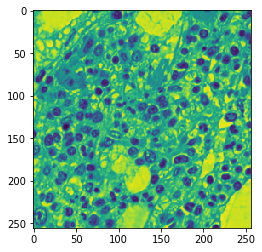

In [15]:
plot_map(x[0])

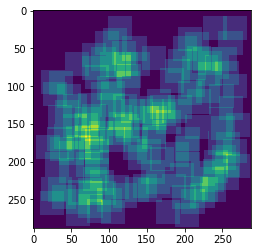

In [16]:
plot_map(y[0])

shuffle the data if needed.

In [17]:
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
c = c[indices]

train-val-test split (8:1:1)

In [18]:
num_train = int(x.shape[0]*0.8)
num_test = int(x.shape[0]*0.1)
train_x = x[:num_train]
train_y = y[:num_train]
train_c = c[:num_train]
val_x = x[num_train:-num_test]
val_y = y[num_train:-num_test]
val_c = c[num_train:-num_test]
test_x = x[-num_test:]
test_y = y[-num_test:]
test_c = c[-num_test:]

load the pre-trained weight.

In [22]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best.h5", by_name=True)
#model.load_weights("models-2/model-cp.100-0.24.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_1 (Add)                     (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_1[0][0]                    
__________

direct test

In [23]:
pred = model.predict(test_x, batch_size=1)
preds = sum_count_map(pred)
tests = np.concatenate(test_c)
print("Test MSE:", np.mean((preds-tests)**2))
print("Test MAE:", np.mean(np.abs(preds-tests)))

Test MSE: 704820.7030148851
Test MAE: 837.7764434814453


In [27]:
preds

array([1006.65637207,  897.25280762,  923.14123535,  999.05535889])

In [28]:
tests

array([111., 125., 127., 112.])

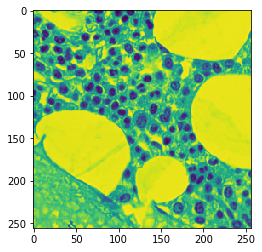

In [24]:
plot_map(test_x[0])

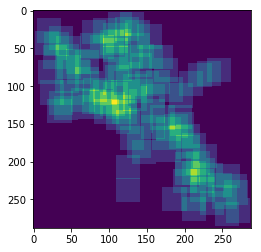

In [25]:
plot_map(test_y[0])

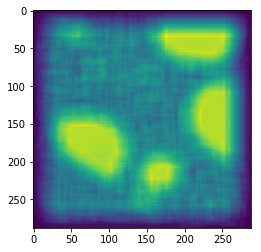

In [26]:
plot_map(pred[0])

In [32]:
batch_size = 4
epochs = 100

In [33]:
bestcheck = ModelCheckpoint(filepath="best-models-3/model-best-MBM256.h5", verbose=1, save_weights_only=True, save_best_only=True)
every10check = ModelCheckpoint(filepath="models-3/model-MBM256-cp.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, period=10, save_weights_only=True)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

hist = model.fit(train_x, train_y, epochs=epochs, initial_epoch=0, batch_size = batch_size,
                 validation_data = (val_x, val_y), 
                 callbacks=[bestcheck, every10check, tbCallBack])

Train on 35 samples, validate on 5 samples
Epoch 1/100
35/35 [==============================] - 9s 263ms/step - loss: 1.3983 - acc: 0.3476 - val_loss: 1.7957 - val_acc: 0.3450

Epoch 00001: val_loss improved from inf to 1.79573, saving model to best-models-3/model-best-MBM256.h5
Epoch 2/100
35/35 [==============================] - 4s 128ms/step - loss: 1.1759 - acc: 0.4076 - val_loss: 1.8347 - val_acc: 0.3597

Epoch 00002: val_loss did not improve from 1.79573
Epoch 3/100
35/35 [==============================] - 4s 127ms/step - loss: 1.0985 - acc: 0.4355 - val_loss: 1.7411 - val_acc: 0.3738

Epoch 00003: val_loss improved from 1.79573 to 1.74108, saving model to best-models-3/model-best-MBM256.h5
Epoch 4/100
35/35 [==============================] - 4s 128ms/step - loss: 1.0517 - acc: 0.4430 - val_loss: 1.5877 - val_acc: 0.3913

Epoch 00004: val_loss improved from 1.74108 to 1.58772, saving model to best-models-3/model-best-MBM256.h5
Epoch 5/100
35/35 [==============================] - 


Epoch 00035: val_loss improved from 0.37538 to 0.36415, saving model to best-models-3/model-best-MBM256.h5
Epoch 36/100
35/35 [==============================] - 4s 127ms/step - loss: 0.7076 - acc: 0.5482 - val_loss: 0.3692 - val_acc: 0.6940

Epoch 00036: val_loss did not improve from 0.36415
Epoch 37/100
35/35 [==============================] - 4s 127ms/step - loss: 0.6940 - acc: 0.5479 - val_loss: 0.3701 - val_acc: 0.6933

Epoch 00037: val_loss did not improve from 0.36415
Epoch 38/100
35/35 [==============================] - 4s 129ms/step - loss: 0.6962 - acc: 0.5527 - val_loss: 0.3654 - val_acc: 0.6973

Epoch 00038: val_loss did not improve from 0.36415
Epoch 39/100
35/35 [==============================] - 4s 128ms/step - loss: 0.6709 - acc: 0.5606 - val_loss: 0.3694 - val_acc: 0.6940

Epoch 00039: val_loss did not improve from 0.36415
Epoch 40/100
35/35 [==============================] - 4s 128ms/step - loss: 0.6826 - acc: 0.5646 - val_loss: 0.3646 - val_acc: 0.6998

Epoch 00040: 

load the best model by validation.

In [34]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best-MBM256.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_3[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_11 (Add)                    (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_3[0][0]                    
__________

test.

In [35]:
# batch size = 1
pred = model.predict(test_x, batch_size=1)
preds = sum_count_map(pred)
tests = np.concatenate(test_c)
print("Test MSE:", np.mean((preds-tests)**2))
print("Test MAE:", np.mean(np.abs(preds-tests)))

Test MSE: 72.73859088675817
Test MAE: 6.080974578857422


In [36]:
tests

array([111., 125., 127., 112.])

In [37]:
preds

array([107.04336548, 124.02284241, 123.8759613 ,  95.7339325 ])

In [ ]:
import numpy as np
np.std(np.abs([107.04336548, 124.02284241, 123.8759613 ,  95.7339325 ]-[111., 125., 127., 112.]))

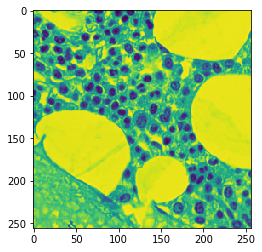

In [38]:
plot_map(test_x[0])

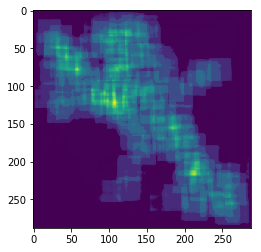

In [39]:
plot_map(pred[0]) # batch size = 1

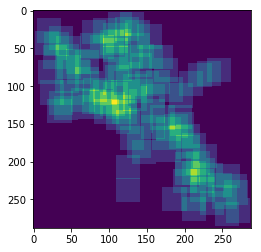

In [40]:
plot_map(test_y[0])

train from scratch.

In [41]:
TRAIN = True 
batch_size = 4
epochs = 100

In [42]:
model = build_model()
bestcheck = ModelCheckpoint(filepath="best-models-3/model-best-MBM256-from-scratch.h5", verbose=1, save_weights_only=True, save_best_only=True)
every10check = ModelCheckpoint(filepath="models-3/model-MBM256-from-scratch-cp.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, period=10, save_weights_only=True)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

hist = model.fit(train_x, train_y, epochs=epochs, initial_epoch=0, batch_size = batch_size,
                 validation_data = (val_x, val_y), 
                 callbacks=[bestcheck, every10check, tbCallBack])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_4[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_16 (Add)                    (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_4[0][0]                    
__________

Train on 35 samples, validate on 5 samples
Epoch 1/100
35/35 [==============================] - 12s 341ms/step - loss: 1.2264 - acc: 0.0847 - val_loss: 7.0364 - val_acc: 0.0269

Epoch 00001: val_loss improved from inf to 7.03637, saving model to best-models-3/model-best-MBM256-from-scratch.h5
Epoch 2/100
35/35 [==============================] - 6s 178ms/step - loss: 1.1702 - acc: 0.0531 - val_loss: 2.9283 - val_acc: 0.0486

Epoch 00002: val_loss improved from 7.03637 to 2.92833, saving model to best-models-3/model-best-MBM256-from-scratch.h5
Epoch 3/100
35/35 [==============================] - 6s 180ms/step - loss: 1.1542 - acc: 0.0534 - val_loss: 2.0945 - val_acc: 0.0545

Epoch 00003: val_loss improved from 2.92833 to 2.09449, saving model to best-models-3/model-best-MBM256-from-scratch.h5
Epoch 4/100
35/35 [==============================] - 6s 178ms/step - loss: 1.1457 - acc: 0.0558 - val_loss: 1.0952 - val_acc: 0.1223

Epoch 00004: val_loss improved from 2.09449 to 1.09520, saving m


Epoch 00040: val_loss did not improve from 0.64562

Epoch 00040: saving model to models-3/model-MBM256-from-scratch-cp.40-0.83.h5
Epoch 41/100
35/35 [==============================] - 6s 177ms/step - loss: 0.7972 - acc: 0.5206 - val_loss: 0.7554 - val_acc: 0.5333

Epoch 00041: val_loss did not improve from 0.64562
Epoch 42/100
35/35 [==============================] - 6s 177ms/step - loss: 0.7880 - acc: 0.5131 - val_loss: 0.7721 - val_acc: 0.5283

Epoch 00042: val_loss did not improve from 0.64562
Epoch 43/100
35/35 [==============================] - 6s 177ms/step - loss: 0.7795 - acc: 0.5194 - val_loss: 0.7606 - val_acc: 0.5257

Epoch 00043: val_loss did not improve from 0.64562
Epoch 44/100
35/35 [==============================] - 6s 177ms/step - loss: 0.7702 - acc: 0.5205 - val_loss: 0.8601 - val_acc: 0.5075

Epoch 00044: val_loss did not improve from 0.64562
Epoch 45/100
35/35 [==============================] - 6s 177ms/step - loss: 0.7611 - acc: 0.5243 - val_loss: 0.7200 - val_acc

Epoch 81/100
35/35 [==============================] - 6s 178ms/step - loss: 0.5062 - acc: 0.6306 - val_loss: 0.5260 - val_acc: 0.6052

Epoch 00081: val_loss did not improve from 0.34478
Epoch 82/100
35/35 [==============================] - 6s 179ms/step - loss: 0.4996 - acc: 0.6323 - val_loss: 0.4704 - val_acc: 0.6335

Epoch 00082: val_loss did not improve from 0.34478
Epoch 83/100
35/35 [==============================] - 6s 178ms/step - loss: 0.4950 - acc: 0.6394 - val_loss: 0.4896 - val_acc: 0.6244

Epoch 00083: val_loss did not improve from 0.34478
Epoch 84/100
35/35 [==============================] - 6s 178ms/step - loss: 0.4858 - acc: 0.6457 - val_loss: 0.5641 - val_acc: 0.5959

Epoch 00084: val_loss did not improve from 0.34478
Epoch 85/100
35/35 [==============================] - 6s 179ms/step - loss: 0.4787 - acc: 0.6512 - val_loss: 0.4516 - val_acc: 0.6410

Epoch 00085: val_loss did not improve from 0.34478
Epoch 86/100
35/35 [==============================] - 6s 179ms/step - 

load the best model

In [43]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best-MBM256-from-scratch.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_5[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_21 (Add)                    (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_5[0][0]                    
__________

test

In [44]:
pred = model.predict(test_x, batch_size=1)
preds = sum_count_map(pred)
tests = np.concatenate(test_c)
print("Test MSE:", np.mean((preds-tests)**2))
print("Test MAE:", np.mean(np.abs(preds-tests)))

Test MSE: 1090.3359922690142
Test MAE: 32.589717864990234


In [45]:
preds

array([84.59391022, 95.62189484, 92.89842224, 71.52690125])

In [46]:
tests

array([111., 125., 127., 112.])

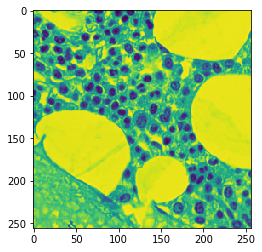

In [47]:
plot_map(test_x[0])

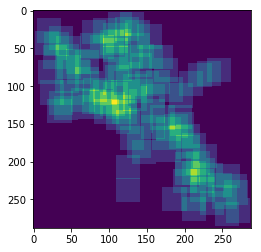

In [48]:
plot_map(test_y[0])

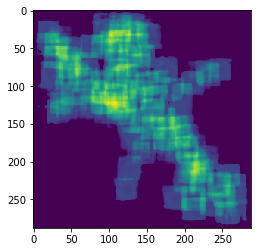

In [49]:
plot_map(pred[0])